In [1]:
import numpy as np
import cv2
import glob
import os
from datetime import datetime as dt
import matplotlib.pyplot as plt
import math
from math import sin, cos, pi, radians, degrees, sqrt, atan2, ceil
import panorama_operations as pano

In [2]:
## estimated with checkerboard calibration
K = np.load('B036_intrintics.npy')
D = np.load('B036_distortion.npy')

In [3]:
## load 4 images
img_north =  cv2.imread('test_images/North_2022-02-09_160021_image.jpg')
img_south =  cv2.imread('test_images/South_2022-02-09_160030_image.jpg')
img_east = cv2.imread('test_images/East_2022-02-09_160225.jpg')
img_west = cv2.imread('test_images/West_2022-02-09_160239.jpg')
img_mask = np.ones([img_west.shape[0], img_west.shape[1], 1], dtype='uint8')

In [4]:
SCALE = 1.0 ## how "far away" to render rectified image
BALANCE = 0.0

## rectify images
img_north, _ = pano.rectify(img_north, K, D, scale=SCALE, balance=BALANCE)
img_south, _ = pano.rectify(img_south, K, D, scale=SCALE, balance=BALANCE)
img_east, _ = pano.rectify(img_east, K, D, scale=SCALE, balance=BALANCE)
img_west, _ = pano.rectify(img_west, K, D, scale=SCALE, balance=BALANCE)
img_mask, K_rectified = pano.rectify(img_mask, K, D, scale=SCALE, balance=BALANCE)

## add an alpha channel
img_north = cv2.cvtColor(img_north, cv2.COLOR_BGR2BGRA)
img_south = cv2.cvtColor(img_south, cv2.COLOR_BGR2BGRA)
img_east = cv2.cvtColor(img_east, cv2.COLOR_BGR2BGRA)
img_west = cv2.cvtColor(img_west, cv2.COLOR_BGR2BGRA)

## update K
K = K_rectified

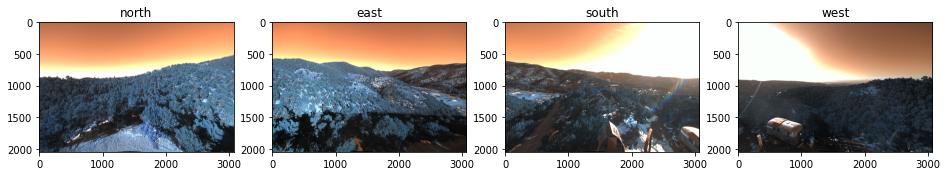

In [5]:
fig, ax = plt.subplots(1,4, figsize=(16,6))
ax[0].imshow(img_north, cmap='gray')
ax[0].set_title('north')
ax[1].imshow(img_east, cmap='gray')
ax[1].set_title('east')
ax[2].imshow(img_south, cmap='gray')
ax[2].set_title('south')
ax[3].imshow(img_west, cmap='gray')
ax[3].set_title('west')
plt.show()

we need to "pan, tilt, zoom" the cameras views to match the real world
translation on the surface of the cylinder equates to rotation IRL
of course, the pixels are warped increasingly as we translate up/down from horizon to pole
(cylindrical projection maps the poles to +/- infinity)

as such, we need to perform these operations _before_ the cylindrical warp

In [6]:
def cylWarp(img, K):
    """
    Fast cylindical warp.
    returns the cylindrical warp for a given image and intrinsics matrix K.
    credit: https://www.morethantechnical.com/2018/10/30/cylindrical-image-warping-for-panorama-stitching/
    """
    h_,w_ = img.shape[:2]
    img = img.copy()

    # pixel coordinates
    y_i, x_i = np.indices((h_,w_))
    X = np.stack([x_i,y_i,np.ones_like(x_i)],axis=-1).reshape(h_*w_,3) # to homog
    
    Kinv = np.linalg.inv(K)
    X = Kinv.dot(X.T).T # "normalized" coords

    # calculate cylindrical coords (sin\theta, h, cos\theta)
    A = np.stack([np.sin(X[:,0]),X[:,1],np.cos(X[:,0])],axis=-1).reshape(w_*h_,3)
    
    # project back to image-pixels plane
    B = K.dot(A.T).T
    
    # back from homog coords
    B = B[:,:-1] / B[:,[-1]]
    
    # make sure warp coords only within image bounds
    B[(B[:,0] < 0) | (B[:,0] >= w_) | (B[:,1] < 0) | (B[:,1] >= h_)] = -1
    B = B.reshape(h_,w_,-1)
    
    return cv2.remap(img, B[:,:,0].astype(np.float32), B[:,:,1].astype(np.float32), cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT)
    
#     img_rgba = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA) # if not already transparent...
#     warp the image according to cylindrical coords
#     return cv2.remap(img_rgba, B[:,:,0].astype(np.float32), B[:,:,1].astype(np.float32), cv2.INTER_AREA, borderMode=cv2.BORDER_TRANSPARENT)

In [7]:
def cylWarpTransform(img, K, r, t):
    """
    rotate and translate an image before cylindrical warp
    img: image to warp. assuming alpha channel right now,
            even numbered dimensions
    K: 3x3 intrinsics matrix
    r: angle to rotate counterclockwise about z axis.. "twist" (degrees)
    t: amount to translate up and down in the y axis. 
                higher numbers point camera down (pixels)
    """
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), r, 1)
    M[1,-1] += t
    output =  cv2.warpAffine(img, M, (w, h))
    return cylWarp(output, K)

In [8]:
## rotation
h, w = img_north.shape[:2]
angle = 5
t = (0, 150) # x, y offsets

M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)

M[0,-1] += t[0]
M[1,-1] += t[1]

test_rot = cv2.warpAffine(img_north, M, (w, h))

In [9]:
print(M)

[[ 9.96194698e-01  8.71557427e-02 -8.34025368e+01]
 [-8.71557427e-02  9.96194698e-01  2.87767850e+02]]


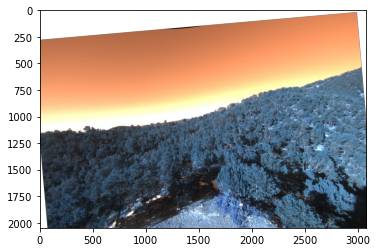

In [10]:
plt.imshow(test_rot)

In [11]:
test_norm_warp = cylWarp(img_north, K)
test_rot_warp = cylWarp(test_rot, K)

In [12]:
## test write
cv2.imwrite('test_norm.png', test_norm_warp)
cv2.imwrite('test_rot.png', test_rot_warp)

True

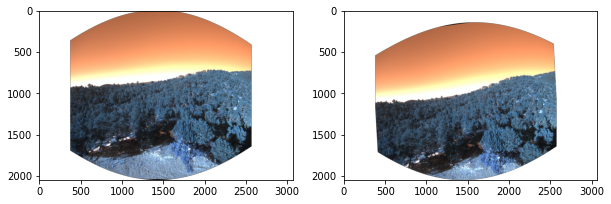

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(test_norm_warp)
ax[1].imshow(test_rot_warp)
plt.show()

In [14]:
%%time
test = cylWarpTransform(img_north, K, -3, -10)

CPU times: user 1.73 s, sys: 1.16 s, total: 2.88 s
Wall time: 947 ms


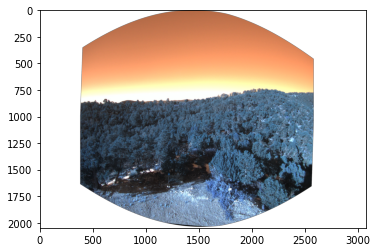

In [15]:
plt.imshow(test)

In [16]:
## test computing key points between images
proj_north = cv2.imread('cylinder_overlap_300_0.png')
proj_east = cv2.imread('cylinder_overlap_300_1.png')

In [17]:
_, proj_north_mask = cv2.threshold(proj_north, 0, 255, cv2.THRESH_BINARY)
proj_north_mask = cv2.cvtColor(proj_north_mask, cv2.COLOR_BGR2GRAY)

_, proj_east_mask = cv2.threshold(proj_east, 0, 255, cv2.THRESH_BINARY)
proj_east_mask = cv2.cvtColor(proj_east_mask, cv2.COLOR_BGR2GRAY)

In [71]:
%%time
c1, c2, d1, d2, matches = pano.getSIFTMatchesPair(proj_north, proj_east, proj_north_mask, proj_east_mask)
M, mask = cv2.estimateAffine2D(c2, c1, cv2.RANSAC, ransacReprojThreshold=1.0)

mask2d = np.hstack((mask, mask))

good_c1 = np.ma.masked_array(c1, mask=mask2d)
good_c2 = np.ma.masked_array(c2, mask=mask2d)

CPU times: user 2min 25s, sys: 2.44 s, total: 2min 27s
Wall time: 24.5 s


In [73]:
len(c1)

996

In [74]:
len(good_c1)

996

array([[  81.56636, 1809.505  ],
       [  87.62692, 2136.4812 ],
       [ 101.16296, 1733.7712 ],
       ...,
       [7325.527  , 1397.3071 ],
       [7482.5366 , 1089.2296 ],
       [7482.6934 , 1436.1921 ]], dtype=float32)

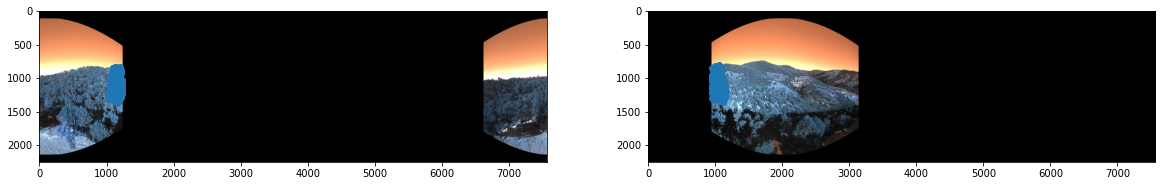

In [19]:
pano.plotFeatureCorr(proj_north, proj_east, c1, c2, mask)

In [31]:
matches[105][0].distance

256.6924133300781

In [30]:
print(mask[105])

[1]


In [33]:
np.array(matches)[:,0].shape

(55375,)

In [35]:
cv2.norm(c1[0] - c2[0])

1027.8233834369328

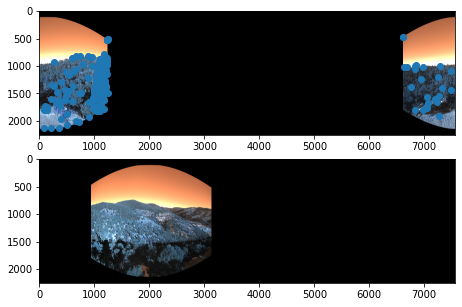

In [72]:
fig, ax = plt.subplots(2,1, figsize=(10,5))
ax[0].imshow(proj_north)
ax[1].imshow(proj_east)


ax[0].scatter(good_c1[:,0], good_c1[:,1])
plt.show()

In [39]:
c1.shape

(996, 2)